In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib.pyplot as plt
import catboost as cb


from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier

from catboost import cv, Pool


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score,RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('./course_project_train.csv', encoding='utf-8')
X_test = pd.read_csv('./course_project_test.csv', encoding='utf-8')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
reduce_mem_usage(df)
reduce_mem_usage(X_test)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.500000,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.700001,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.700000,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.000000,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.600000,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.100000,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,100000000.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.000000,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.800000,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.799999,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [5]:
#df_with_dummies = pd.get_dummies(df, columns=['Home Ownership', 'Years in current job','Purpose','Term'])

#X_test = pd.get_dummies(df, columns=['Home Ownership', 'Years in current job','Purpose','Term'])

In [6]:
for colname in ['Home Ownership', 'Years in current job','Purpose','Term']:
    df[colname] = df[colname].astype(str)

In [7]:
#X = df_with_dummies.drop('Credit Default', axis=1)
X = df.drop('Credit Default', axis=1)
#y = df_with_dummies['Credit Default']
y = df['Credit Default']

In [8]:
cat_features = ['Home Ownership', 'Years in current job','Purpose','Term']

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.25, random_state=64)

In [10]:
eval_dataset = Pool(X_validation,
                    y_validation,
                   cat_features=cat_features)

In [11]:
model = CatBoostClassifier(learning_rate=0.04,
                           depth=6 ,
                           cat_features=cat_features,
                           custom_metric=['F1'])

model.fit(X_train,
          y_train,
          eval_set=eval_dataset,
          verbose=False)

print(model.get_best_score())

{'learn': {'F1': 0.9924098671726755, 'Logloss': 0.1139780440843943}, 'validation': {'F1': 0.45548654244306425, 'Logloss': 0.4777493838806285}}


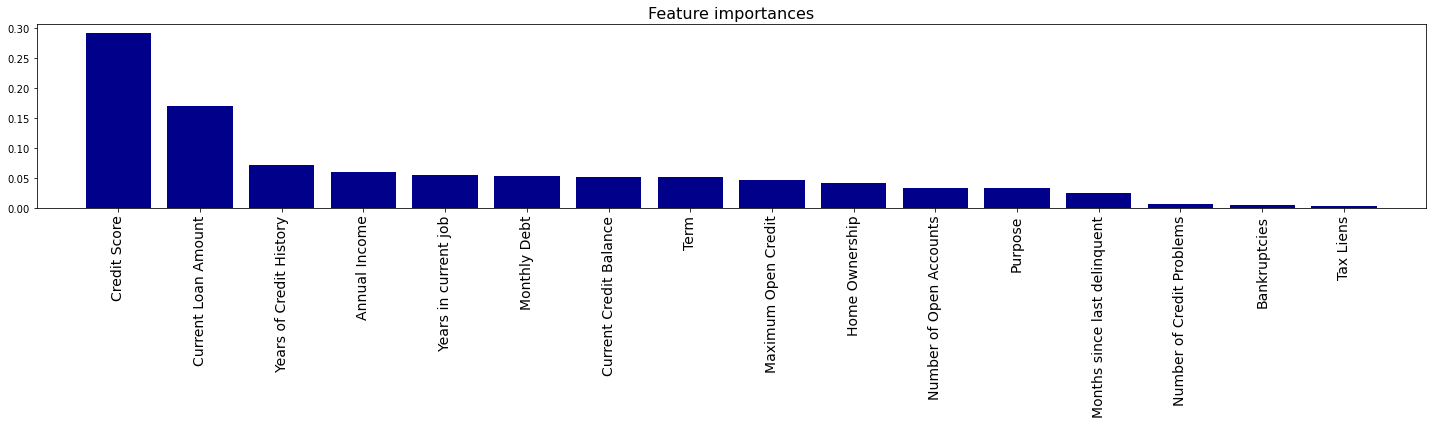

In [12]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [13]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model.feature_importances_ / model.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [14]:
feature_importances

,feature_name,importance
15,Credit Score,0.291698
12,Current Loan Amount,0.169997
5,Years of Credit History,0.072182
1,Annual Income,0.060114
2,Years in current job,0.055152
14,Monthly Debt,0.053094
13,Current Credit Balance,0.052145
11,Term,0.051402
6,Maximum Open Credit,0.047186
0,Home Ownership,0.041645


Обзор данных
Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)